In [1]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [3]:
# Load dataset
dataset = load_dataset("armanc/pubmed-rct20k")
train_data = dataset['train']
valid_data = dataset['validation']

Repo card metadata block was not found. Setting CardData to empty.


In [4]:
# Binary label mappings
target_names = ["background", "finding"]
label2id = {"background": 0, "finding": 1}
id2label = {0: "background", 1: "finding"}

# Map labels to binary
def map_label(original_label):
    return "finding" if original_label in ["results", "conclusions"] else "background"

# Load pretrained SciBERT model
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
encoder = AutoModel.from_pretrained(model_name).to(device)
encoder.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31090, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [5]:
# Function to extract embeddings
def get_pooled_cls_embeddings(text_list, batch_size=16):
    embeddings = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Extracting embeddings"):
        batch_texts = text_list[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=256).to(device)
        with torch.no_grad():
            outputs = encoder(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        last_four = torch.stack(hidden_states[-4:], dim=0)
        pooled = last_four.mean(dim=0)[:, 0, :]
        embeddings.append(pooled.cpu().numpy())
    return np.vstack(embeddings)

In [6]:
# Embeddings caching
if os.path.exists("train_embeddings_binary.npy") and os.path.exists("valid_embeddings_binary.npy"):
    X_train = np.load("train_embeddings_binary.npy")
    y_train = np.load("train_labels_binary.npy", allow_pickle=True)
    X_valid = np.load("valid_embeddings_binary.npy")
    y_valid = np.load("valid_labels_binary.npy", allow_pickle=True)
    print("Loaded cached embeddings")
else:
    train_texts = [item['text'] for item in train_data]
    y_train = np.array([label2id[map_label(item['label'])] for item in train_data])
    X_train = get_pooled_cls_embeddings(train_texts)

    valid_texts = [item['text'] for item in valid_data]
    y_valid = np.array([label2id[map_label(item['label'])] for item in valid_data])
    X_valid = get_pooled_cls_embeddings(valid_texts)

    np.save("train_embeddings_binary.npy", X_train)
    np.save("train_labels_binary.npy", y_train)
    np.save("valid_embeddings_binary.npy", X_valid)
    np.save("valid_labels_binary.npy", y_valid)
    print("Saved embeddings")

Extracting embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1855/1855 [00:50<00:00, 36.53it/s]


Saved embeddings


In [7]:
# Train Logistic Regression classifier
clf = LogisticRegression(max_iter=3000, random_state=42)
clf.fit(X_train, y_train)

# Save trained classifier
joblib.dump(clf, "logistic_classifier_binary.pkl")
print("Saved Logistic Regression model")

Saved Logistic Regression model



Binary Classification Report:
              precision    recall  f1-score   support

  background     0.9445    0.9570    0.9507     15249
     finding     0.9539    0.9406    0.9472     14423

    accuracy                         0.9490     29672
   macro avg     0.9492    0.9488    0.9490     29672
weighted avg     0.9491    0.9490    0.9490     29672



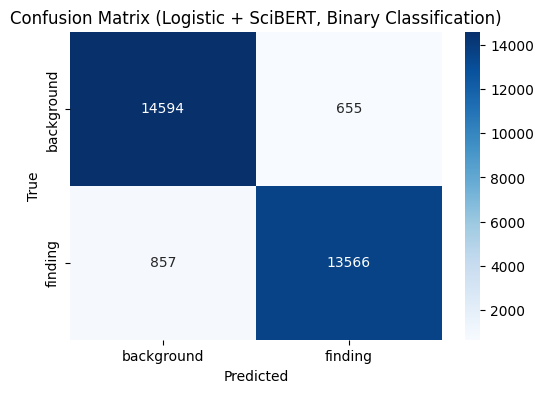

In [8]:
# Evaluate model
y_pred = clf.predict(X_valid)

print("\nBinary Classification Report:")
report = classification_report(y_valid, y_pred, labels=[0,1], target_names=target_names, digits=4)
print(report)

# Save classification report
with open("classification_report_binary.txt", "w") as f:
    f.write(report)

# Plot confusion matrix
cm = confusion_matrix(y_valid, y_pred, labels=[0,1])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Logistic + SciBERT, Binary Classification)')
plt.savefig("confusion_matrix_binary.png")
plt.show()
